In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import utils
from torch.utils.data import DataLoader
import tqdm as tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from utils import load_csv, drop_cols, remove_strings, groupedAvg, subsample, normalize
from create_dataset import AnimalDataset, AnimalDatasetEmbedding, UnpairedDataset
from generators import EmbeddingEncoderDecoderGenerator, EmbeddingUnetGenerator, UnpairedEncoderDecoder 
from discriminators import MultiChannelDiscriminator 

/home/johann/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# config

ALLDATA = True # if False -> smaller dataset
UNPAIRED = False # if True -> unpaired dataset

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 512  
LEARNING_RATE = 1e-4  # 1e-5 was too small for 'LVtot_kalibriert' and 'LVtot' 
NUM_WORKERS = 10
NUM_EPOCHS = 600
LR_DECAY_AFTER_EPOCH = 300  
GENERATION_AFTER_EPOCH = NUM_EPOCHS # number of epochs after which the model generates a sample
SIG_A = "AoP"           # Drucksignal Hauptschlagader = Aortendruck
SIG_B = "VADcurrent"    # VAD Strom [A] – Pumpemstrom in Ampere
SIG_C = "VadQ"          # Fluss durch VAD (VAD = Ventrikular assistance device = Pumpe) = Pumpenfluss
SIG_D = "LVP"           # Ventrikeldruck links = Drucksignal der linken Herzkammer
TARGET = "LVtot_kalibriert"
feature_names = [SIG_A, SIG_C, SIG_D]
CHANNELS = len(feature_names)
WINDOW = 256
target = TARGET

SKIPCONNECTIONS = False
EMBEDDING = True

# Abailable Generators
# GENERATOR = OneChannelUnetGenerator or MultiChannelUnetGenerator or SkipConnectionsMultiChannelUnetGenerator

# Available Discminators
# DISCRIMINTOR = OneChannelDiscriminator or MultiChannelDiscriminator


load_from_epoch = 900  # select which Generator to load
gen_B_filename = 'Checkpoints/GenB_FeatureNames_{}_Target_[{}]_BatchSize_[{}]_LR_[{}]_Epoch_[{}].pth.tar'.format(feature_names, target, BATCH_SIZE, LEARNING_RATE, load_from_epoch)
gen_A_filename = 'Checkpoints/GenA_FeatureNames_{}_Target_[{}]_BatchSize_[{}]_LR_[{}]_Epoch_[{}].pth.tar'.format(feature_names, target, BATCH_SIZE, LEARNING_RATE, load_from_epoch)
disc_B_filename = 'Checkpoints/DiscB_FeatureNames_{}_Target_[{}]_BatchSize_[{}]_LR_[{}]_Epoch_[{}].pth.tar'.format(feature_names, target, BATCH_SIZE, LEARNING_RATE, load_from_epoch)
disc_A_filename = 'Checkpoints/DiscA_FeatureNames_{}_Target_[{}]_BatchSize_[{}]_LR_[{}]_Epoch_[{}].pth.tar'.format(feature_names, target, BATCH_SIZE, LEARNING_RATE, load_from_epoch)

CHECKPOINT_GEN_B = gen_B_filename
CHECKPOINT_GEN_A = gen_A_filename
CHECKPOINT_DISC_B =  disc_B_filename
CHECKPOINT_DISC_A =  disc_A_filename
LOAD_MODEL = False
SAVE_MODEL = False
SAVE_EPOCH = 100


# Use cycle consistency loss
CYCLE = True
LAMBDA_CYCLE = 5.0
# Use supervised loss
SUPERVISED = True  # only supervised true, 1500 epochs, decay after 500 epochs -> l1 loss ~ 0.4
LAMBDA_SUPERVISED = 5.0
# Use adversarial loss
ADVERSARIAL = True
LAMBDA_ADVERSARIAL = 5.0
# Use Identity loss
IDENTITY = False
LAMBDA_IDENTITY = 10.0

In [3]:
if ALLDATA == False:
    # load only a small part of the data and drop the unnecessary columns
    # paths of only a small part of the data
    path = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports_not_all_the_data/constant_speed_interventions/" 
    df = utils.load_csv(path)
    df = utils.drop_cols(df)
    df = df.dropna()

    # select only rows where 'Phasenzuordnung' is 1
    # df = df.loc[df['Phasenzuordnung'] == 1]

    print(df.shape) 

In [4]:
if ALLDATA == True:
    # Load all the data and drop unnecessary columns
    # We load the data separately, to avoid a Runtime error

    # all the data
    path_1 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_1"  
    path_2 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_2"
    path_3 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_3"
    # path_4 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_4"

    df_1 = utils.load_csv(path_1)
    df_1 = utils.drop_cols(df_1)

    df_2 = utils.load_csv(path_2)
    df_2 = utils.drop_cols(df_2)

    df_3 = utils.load_csv(path_3)
    df_3 = utils.drop_cols(df_3)

    # df_4 = utils.load_csv(path_4)
    # df_4 = utils.drop_cols(df_4)

    # concatenate the separate dataframes
    df = pd.concat([df_1, df_2, df_3], axis=0, ignore_index=True)
    df = df.dropna()

    print('Size of the whole dataset',df.shape)
    # select only rows where 'Phasenzuordnung' is 1
    # df = df.loc[df['Phasenzuordnung'] == 1]
    # print('Size of dataset with only the first phase',df.shape)

Size of the whole dataset (51661992, 13)


In [5]:
df = utils.remove_strings(df)
df = utils.subsample(df, 10)

Get dataset size (no subsampling)

In [6]:
# import os


# def load_df(path):
#     df = utils.load_csv(path)
#     df = utils.drop_cols(df)
#     df = df.dropna()
#     return df


# if ALLDATA == True:
#     # Load all the data and drop unnecessary columns
#     # We load the data separately, to avoid a Runtime error

#     # all the data
#     base_path = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/"
#     paths = [os.path.join(base_path, f"Data_split_{i}") for i in range(1, 5)]

#     df = pd.concat([load_df(path) for path in paths], axis=0, ignore_index=True)
    
#     print('Size of the whole dataset',df.shape)
#     # select only rows where 'Phasenzuordnung' is 1
#     # df = df.loc[df['Phasenzuordnung'] == 1]
#     # print('Size of dataset with only the first phase',df.shape)
# else:
#     # load only a small part of the data and drop the unnecessary columns
#     # paths of only a small part of the data
#     path = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports_not_all_the_data/constant_speed_interventions/" 

#     df = load_df(path)

#     # select only rows where 'Phasenzuordnung' is 1
#     # df = df.loc[df['Phasenzuordnung'] == 1]

#     print(df.shape) 

In [7]:
# print(df.shape)
# df = utils.remove_strings(df)
# print(df.shape)
# df = utils.subsample(df, 10)
# print(df.shape)
# utils.visualize(df, SIG_A, SIG_B, SIG_C, SIG_D, 5000)

In [8]:
df_IPA = df[['intervention', 'Phasenzuordnung', 'animal']]

(5166199, 13)
(5166199, 13)


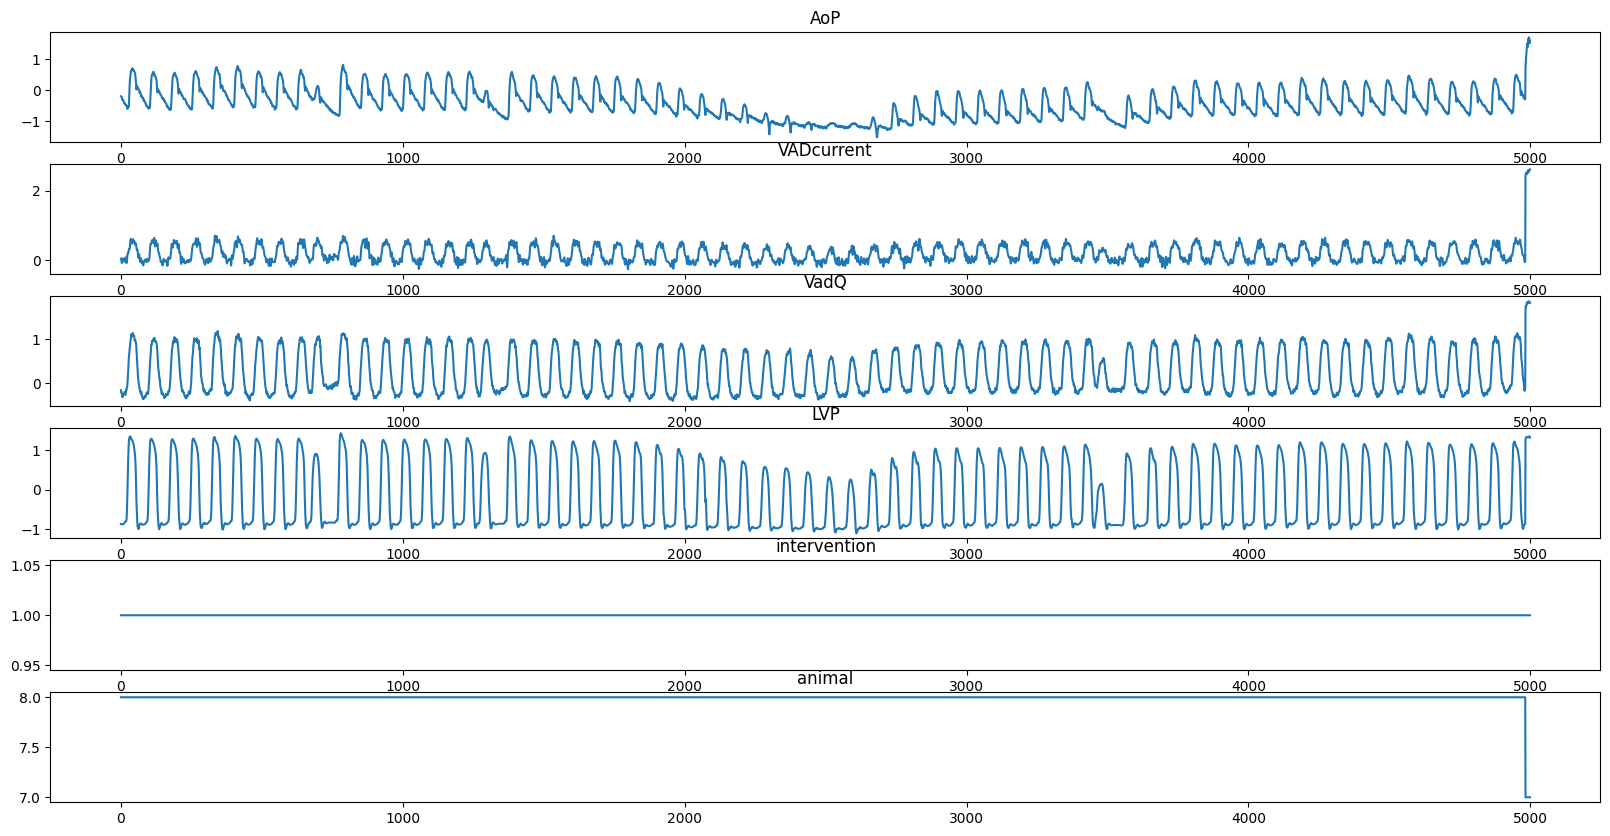

In [9]:
# split df into separate dataframes for each animal
scaler = StandardScaler()
df_temp = pd.DataFrame()

#utils.visualize(df, [SIG_A, SIG_B, SIG_C, SIG_D, 'intervention', 'animal'], 72094)

for animal in df['animal'].unique():
    # split df into separate dataframes for each animal
    df_animal = df.loc[df['animal'] == animal]
    df_animal = utils.normalize(df_animal, scaler)
    # append df_animal to df_temp
    df_temp = pd.concat([df_temp, df_animal], axis=0, ignore_index=True)

print(df.shape)
print(df_temp.shape)
df = df_temp
df = df.drop(columns=['intervention', 'Phasenzuordnung', 'animal'])
df = df.join(df_IPA)
utils.visualize(df, [SIG_A, SIG_B, SIG_C, SIG_D, 'intervention', 'animal'], 5000)

In [10]:
# get number of rows where 'animal' is empty
print(df.loc[df['animal'] == ''].shape)
# drop rows where 'animal' is empty
df = df.drop(df.loc[df['animal'] == ''].index)
print(df.shape)

(0, 13)
(5166199, 13)


In [11]:
# df = utils.remove_strings(df)
# df = utils.subsample(df, 10)
# df = utils.normalize(df)

# print(df.shape)

In [12]:
# utils.visualize(df, SIG_A, SIG_B, SIG_C, SIG_D, 512)

In [13]:
# utils.visualize(df, TARGET, SIG_A, SIG_B, SIG_D, 512)

In [14]:
# Which different intervention ids are there?
print('\nDifferent interventions: \n',df['intervention'].unique())

# How many different intervention ids are there?
print('\nNumber of different interventions: \n',len(df['intervention'].unique()))

# Which different phases are there?
print('\nDifferent phases (Phasenzuordnung): \n',df['Phasenzuordnung'].unique())

# hom many different phases are there?
print('\nNumber of different phases (Phasenzuordnung): \n',len(df['Phasenzuordnung'].unique()))

# hom many different animal ids are there?
print('\nDifferent animal IDs: \n',len(df['animal'].unique()))

# remove animals with less than 10 data points
df = df.groupby('animal').filter(lambda x: len(x) > 10)
print('\nDifferent animal IDs after removing those with less than 10 data points: \n',len(df['animal'].unique()))

# length of data per animal
#print(df.groupby('animal').size())

all_animals = df['animal'].unique()
# pick 2 random animals for test data
test_animals = df['animal'].sample(n=1, random_state=42).unique()

# remove test animals from train animals
train_animals =  [x for x in all_animals if x not in test_animals]

print('\nTest animals:', test_animals)
# test data
df_test = df[df['animal'].isin(test_animals)]

# train dataframe with only animals from train_animals
df_train = df[df['animal'].isin(train_animals)]
print('\nDifferent animal IDs after removing those that are in the test dataset: \n',len(df_train['animal'].unique()))


print('\nTrain data shape:', df_train.shape)
print('\nTest data shape:', df_test.shape)

#print('Unique animals in df_train: ',df_train['animal'].unique())
#print('Unique animals in df_test: ',df_test['animal'].unique())

# lengt of df_train
print('\nThe test dataset is {} percent of the whole data: '.format((len(df_test)/(len(df_train) + len(df_test))) * 100))


Different interventions: 
 [ 1.  4. 10.  9.  5.  3.  2.  8.  6.  7.]

Number of different interventions: 
 10

Different phases (Phasenzuordnung): 
 [1 2 3 4 5]

Number of different phases (Phasenzuordnung): 
 5

Different animal IDs: 
 19

Different animal IDs after removing those with less than 10 data points: 
 17

Test animals: [15]

Different animal IDs after removing those that are in the test dataset: 
 16

Train data shape: (4631040, 13)

Test data shape: (535148, 13)

The test dataset is 10.358662905802111 percent of the whole data: 


In [15]:
if SKIPCONNECTIONS and EMBEDDING:
    # initialize generator and discriminator
    gen_B = EmbeddingUnetGenerator(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1).to(DEVICE)
    gen_A = EmbeddingUnetGenerator(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS).to(DEVICE)
if not SKIPCONNECTIONS and EMBEDDING:
    gen_B = EmbeddingEncoderDecoderGenerator(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1).to(DEVICE)
    gen_A = EmbeddingEncoderDecoderGenerator(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS).to(DEVICE)

# if not SKIPCONNECTIONS and EMBEDDING and UNPAIRED:
#     gen_B = UnpairedEncoderDecoder(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1).to(DEVICE)
#     gen_A = UnpairedEncoderDecoder(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS).to(DEVICE)


disc_B = MultiChannelDiscriminator(CHANNELS = 1).to(DEVICE)
disc_A = MultiChannelDiscriminator(CHANNELS = CHANNELS).to(DEVICE)

# optimizers for discriminator and generator 
opt_disc = torch.optim.AdamW(                                         
    list(disc_A.parameters()) + list(disc_B.parameters()), 
    lr=LEARNING_RATE, 
)
opt_gen = torch.optim.AdamW(
    list(gen_A.parameters()) + list(gen_B.parameters()),
    lr=LEARNING_RATE,
)


# maybe a step learning rate would be a good idea 1e-4 -> 1e-5
# scheduler
gen_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer = opt_gen,
                                                      total_iters = NUM_EPOCHS-LR_DECAY_AFTER_EPOCH, 
                                                      power = 1,
                                                    )
disc_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer = opt_disc,
                                                       total_iters = NUM_EPOCHS-LR_DECAY_AFTER_EPOCH, 
                                                       power = 1,
                                                    )
# losses
l1 = nn.L1Loss() # L1 loss for cycle consistency and identity loss
mse = nn.MSELoss() # MSE loss for adversarial loss

if LOAD_MODEL:
    utils.load_checkpoint(CHECKPOINT_GEN_B, gen_B, opt_gen, LEARNING_RATE)
    utils.load_checkpoint(CHECKPOINT_GEN_A, gen_A, opt_gen, LEARNING_RATE)
    utils.load_checkpoint(CHECKPOINT_DISC_B, disc_B, opt_disc, LEARNING_RATE)
    utils.load_checkpoint(CHECKPOINT_DISC_A, disc_A, opt_disc, LEARNING_RATE)

# create datasets  
if EMBEDDING:
    if UNPAIRED:
        train_dataset = UnpairedDataset(df_train, feature_names, target_name = target, test = False, window_length = WINDOW)
        test_dataset = UnpairedDataset(df_test, feature_names, target_name = target, test = True, window_length = WINDOW)
        gen_dataset = UnpairedDataset(df_test, feature_names, target_name = target, test = True, window_length = WINDOW)
    else:
        train_dataset = AnimalDatasetEmbedding(df_train, feature_names, target_name = target, test = False, window_length = WINDOW)
        test_dataset = AnimalDatasetEmbedding(df_test, feature_names, target_name = target, test = True, window_length = WINDOW)
        gen_dataset = AnimalDatasetEmbedding(df_test, feature_names, target_name = target, test = False, window_length = WINDOW)
else:
    train_dataset = AnimalDataset(df_train, feature_names, target_name = target, test = False, window_length = WINDOW)
    test_dataset = AnimalDataset(df_test, feature_names, target_name = target, test = True, window_length = WINDOW)
    gen_dataset = AnimalDataset(df_test, feature_names, target_name = target, test = False, window_length = WINDOW)



# Data loader
loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True,)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,)
gen_loader = DataLoader(gen_dataset, batch_size=1, shuffle=True, pin_memory=True,)

# run in float16
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()


train_losses = {
            'Discriminator A loss' : [],
            'Discriminator B loss' : [],
            'Total Discriminator loss' : [],
            'Adversarial loss A' : [],
            'Adversarial loss B' : [],
            'Cycle consistency loss A' : [],
            'Cycle consistency loss B' : [],
            'Total Generator loss' : [],
            'Supervised loss A' : [],
            'Supervised loss B' : [],
        }

test_losses = {
            'Discriminator A loss' : [],
            'Discriminator B loss' : [],
            'Total Discriminator loss' : [],
            'Adversarial loss A' : [],
            'Adversarial loss B' : [],
            'Cycle consistency loss A' : [],
            'Cycle consistency loss B' : [],
            'Total Generator loss' : [],
            'L1 loss between real signal A and fake signals A' : [],
            'L1 loss between real signal B and fake signals B' : [],
            'L1_realA_fakeB' : [],
            'L1_realB_fakeA' : [],
            'Supervised loss A' : [],
            'Supervised loss B' : [],
        }

In [16]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: johann4dl (johannanton). Use `wandb login --relogin` to force relogin


In [17]:
def discriminator_loss(disc, reals, fakes):
    # calculate how close reals are to being classified as real
    real_loss = mse(disc(reals), torch.ones_like(disc(reals)))
    # calculate how close fakes are to being classified as fake
    fake_loss = mse(disc(fakes), torch.zeros_like(disc(fakes)))
    # return the average of real and fake loss
    return (real_loss + fake_loss) / 2


@torch.cuda.amp.autocast()
def get_disc_loss(sig_A, sig_B, phase, intervention, 
                    disc_A, disc_B, gen_A, gen_B, fake_A, fake_B
                    ):
    """
    Return the loss of the discriminator given inputs.
    """
    # generate fakes
    # with torch.no_grad():
    #     fake_B = gen_B(sig_A, phase, intervention).detach()
    #     fake_A = gen_A(sig_B, phase, intervention).detach()
    
    # discriminator loss
    disc_B_loss = discriminator_loss(disc_B, sig_B, fake_B)
    disc_A_loss = discriminator_loss(disc_A, sig_A, fake_A)
    disc_loss = (disc_A_loss + disc_B_loss) / 2

    return disc_loss, disc_A_loss, disc_B_loss

@torch.cuda.amp.autocast()
def calc_gen_loss(sig_A, sig_B, phase, intervention,
                  gen_A, gen_B, disc_A, disc_B, fake_B, fake_A
                  ):
    loss = 0

    if ADVERSARIAL:
        # ----- adversarial loss for both generators ----- #
        # fake_B = gen_B(sig_A, phase, intervention).detach()
        # fake_A = gen_A(sig_B, phase, intervention).detach()
        # d_A_fake = disc_A(fake_A) # disc_A should output 0 for fake signal A
        # d_B_fake = disc_B(fake_B) # disc_B should output 0 for fake signal B
        # loss between discriminator output and 0 - The discriminator should output 0 for fake signals
        g_A_loss = l1(disc_A(fake_A), torch.ones_like(disc_A(fake_A))) # was ones_like before
        g_B_loss = l1(disc_B(fake_B), torch.ones_like(disc_B(fake_B))) # was ones_like before

        loss += g_A_loss * LAMBDA_ADVERSARIAL + g_B_loss * LAMBDA_ADVERSARIAL
    else:
        g_A_loss = torch.tensor(0)
        g_B_loss = torch.tensor(0)

    if SUPERVISED:
        # supervised A loss
        # fake_B = gen_B(sig_A, phase, intervention).detach()
        # fake_A = gen_A(sig_B, phase, intervention).detach()
        sup_A_loss = l1(sig_A, fake_A)
        sup_B_loss = l1(sig_B, fake_B)

        loss += sup_A_loss * LAMBDA_SUPERVISED + sup_B_loss * LAMBDA_SUPERVISED
    else:
        sup_A_loss = torch.tensor(0)
        sup_B_loss = torch.tensor(0)

    if CYCLE:
        # ----- cycle consistency loss ----- #
        # fake_B = gen_B(sig_A, phase, intervention).detach()
        # fake_A = gen_A(sig_B, phase, intervention).detach()
        cycle_B = gen_B(fake_A, phase, intervention)
        cycle_A = gen_A(fake_B, phase, intervention)
        cycle_B_loss = l1(sig_B, cycle_B)  # l1 loss: Mean absolute error between each element in the input x and target y.
        cycle_A_loss = l1(sig_A, cycle_A)  # l1 loss in cycle GAN paper

        loss += cycle_B_loss * LAMBDA_CYCLE + cycle_A_loss * LAMBDA_CYCLE
    else:
        cycle_B_loss = torch.tensor(0)
        cycle_A_loss = torch.tensor(0)

    if IDENTITY:
    # ----- identity loss ----- #
        # fake_B = gen_B(sig_A, phase, intervention)
        # fake_A = gen_A(sig_B, phase, intervention)
        # id_B = gen_B(sig_B, phase, intervention)
        # id_A = gen_A(sig_A, phase, intervention)
        id_B_loss = l1(sig_B, gen_B(sig_B, phase, intervention))
        id_A_loss = l1(sig_A, gen_A(sig_A, phase, intervention))

        loss += id_B_loss * LAMBDA_IDENTITY + id_A_loss * LAMBDA_IDENTITY
    else:
        id_B_loss = torch.tensor(0)
        id_A_loss = torch.tensor(0)

    return loss, g_A_loss, g_B_loss, cycle_B_loss, cycle_A_loss, id_B_loss, id_A_loss, sup_A_loss, sup_B_loss

  2%|▏         | 9/600 [01:13<1:20:07,  8.13s/it]/home/johann/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([512, 1, 256])) that is different to the input size (torch.Size([512, 3, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/johann/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([512, 3, 256])) that is different to the input size (torch.Size([512, 1, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/johann/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([512, 1, 256])) that is different to the input

Generate fake signals
Training finished


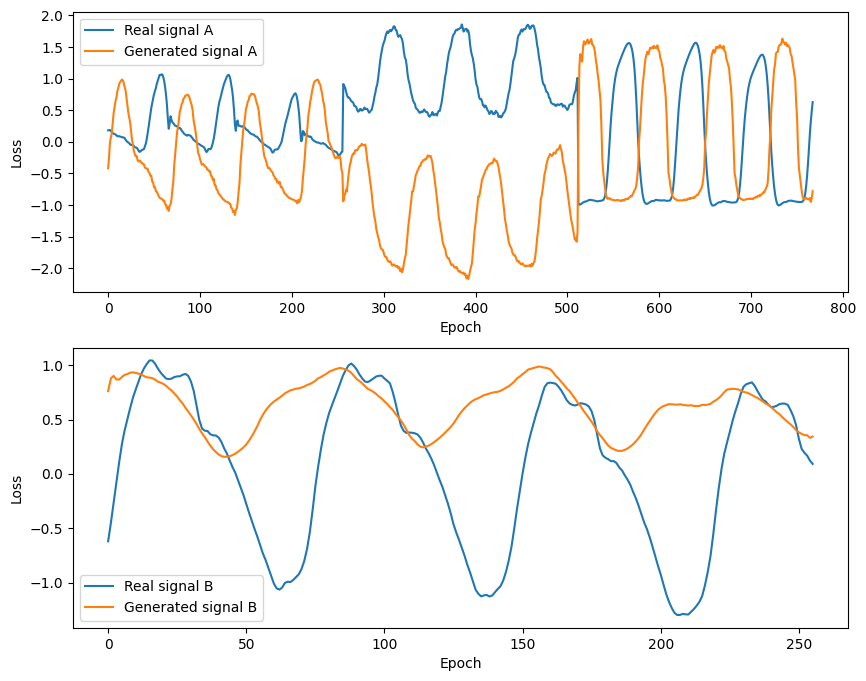

In [18]:
# training loop
from tqdm.auto import tqdm

for epoch in tqdm(range(NUM_EPOCHS)):

    for sig_A, sig_B, phase, intervention in loader:
        # convert to float16
        sig_A = sig_A.float() # neccessary to prevent error: "Input type (torch.cuda.DoubleTensor) 
        sig_B = sig_B.float() # and weight type (torch.cuda.HalfTensor) should be the same"
    
        # move to GPU
        sig_A = sig_A.to(DEVICE)
        sig_B = sig_B.to(DEVICE)
        phase = phase.to(DEVICE)
        intervention = intervention.to(DEVICE)

        #  -------------------------------- #
        #  ----- train discriminators ----- #
        #  -------------------------------- #
        with torch.no_grad():
            fake_B = gen_B(sig_A, phase, intervention).detach()
            fake_A = gen_A(sig_B, phase, intervention).detach()

        d_loss, disc_A_loss, disc_B_loss = get_disc_loss(sig_A, sig_B, phase, intervention,
                                                            disc_A, disc_B, gen_A, gen_B, 
                                                            fake_A, fake_B
                                                        )

        # update gradients of discriminator 
        opt_disc.zero_grad() 
        d_scaler.scale(d_loss).backward()  
        d_scaler.step(opt_disc)  
        d_scaler.update()
        

        # -------------------------------- #
        # ------- train generators ------- #
        # -------------------------------- # 

        out = calc_gen_loss(sig_A, sig_B, phase, intervention,
                                gen_A, gen_B, disc_A, disc_B, 
                                fake_B, fake_A
                                )
        g_loss, g_A_loss, g_B_loss, cycle_B_loss, cycle_A_loss, id_B_loss, id_A_loss, sup_A_loss, sup_B_loss = out

        # update gradients of generator
        opt_gen.zero_grad()
        g_scaler.scale(g_loss).backward() 
        g_scaler.step(opt_gen) 
        g_scaler.update()

        # now we packge the above into a function
        # and call it in the training loop

        

    # save losses
    train_losses['Discriminator A loss'].append(disc_A_loss.item())
    train_losses['Discriminator B loss'].append(disc_B_loss.item())
    train_losses['Total Discriminator loss'].append(d_loss.item())
    if ADVERSARIAL:
        train_losses['Adversarial loss A'].append(g_A_loss.item())
        train_losses['Adversarial loss B'].append(g_B_loss.item())
    if CYCLE:
        train_losses['Cycle consistency loss A'].append(cycle_A_loss.item())
        train_losses['Cycle consistency loss B'].append(cycle_B_loss.item())
    if SUPERVISED:
        train_losses['Supervised loss A'].append(sup_A_loss.item())
        train_losses['Supervised loss B'].append(sup_B_loss.item())
    train_losses['Total Generator loss'].append(g_loss.item())
    #train_losses['Identity loss A'].append(id_A_loss.item())
    #train_losses['Identity loss B'].append(id_B_loss.item())
    
    wandb.log({'Train/Discriminator A loss': disc_A_loss.item(),
                'Train/Discriminator B loss': disc_B_loss.item(),
                'Train/Total Discriminator loss': d_loss.item(),
                'Train/Total Generator loss': g_loss.item(),
                'Train/Adversarial loss A': g_A_loss.item(),
                'Train/Adversarial loss B': g_B_loss.item(),
                'Train/Cycle consistency loss A': cycle_A_loss.item(),
                'Train/Cycle consistency loss B': cycle_B_loss.item()
                'Train/Supervised loss A': sup_A_loss.item(),
                'Train/Supervised loss B': sup_B_loss.item(),
                # 'Train/Identity loss A': id_A_loss.item(),
                # 'Train/Identity loss B': id_B_loss.item()
                })
    # ------------------------ #
    # ------ Validation ------ #
    # ------------------------ #

    #  validation every 10 epochs
    if (epoch+1) % 10 == 0:

        with torch.no_grad():
            # set models to evaluation mode
            disc_A.eval()  # set discriminator to evaluation mode
            disc_B.eval()  # turns off Dropouts Layers, BatchNorm Layers etc
            gen_B.eval()
            gen_A.eval()

            for sig_A, sig_B, phase, intervention in test_loader:
                # convert to float16
                sig_A = sig_A.float()
                sig_B = sig_B.float()

                # move to GPU
                sig_A = sig_A.to(DEVICE)
                sig_B = sig_B.to(DEVICE)
                phase = phase.to(DEVICE)
                intervention = intervention.to(DEVICE)

                fake_B = gen_B(sig_A, phase, intervention).detach()
                fake_A = gen_A(sig_B, phase, intervention).detach()

        
                # calculate l1 loss of fake signals and real signals
                test_L1_real_fake_B = l1(sig_B, fake_B)   # l1(sig_B, fake_B)
                test_L1_real_fake_A = l1(sig_A, fake_A)   # l1(sig_A, fake_A)

                


                # -------------------------------- #
                # ------- test generators -------- #
                # -------------------------------- # 

                out = calc_gen_loss(sig_A, sig_B, phase, intervention,
                                        gen_A, gen_B, disc_A, disc_B, 
                                        fake_B, fake_A
                                        )
                g_lossT, g_A_lossT, g_B_lossT, cycle_B_lossT, cycle_A_lossT, id_B_lossT, id_A_lossT, sup_A_lossT, sup_B_lossT = out



                test_Total_Generator_loss = 0 # initialize
                # calculate adversarial loss
                if ADVERSARIAL:
                    test_Adversaral_loss_B = mse(disc_B(fake_B), torch.ones_like(disc_B(fake_B))) 
                    test_Adversaral_loss_A = mse(disc_A(fake_A), torch.ones_like(disc_A(fake_A)))

                    test_Total_Generator_loss += test_Adversaral_loss_A * LAMBDA_ADVERSARIAL + test_Adversaral_loss_B * LAMBDA_ADVERSARIAL 

                # ----- cycle loss ----- #
                if CYCLE:
                    cycle_B = gen_B(fake_A, phase, intervention)  # fake_A = gen_B2A(sig_B)
                    cycle_A = gen_A(fake_B, phase, intervention)  # fake_B = gen_A2B(sig_A)
                    test_Cycle_consistency_loss_B = l1(sig_B, cycle_B)
                    test_Cycle_consistency_loss_A = l1(sig_A, cycle_A)

                    test_Total_Generator_loss += test_Cycle_consistency_loss_B * LAMBDA_CYCLE + test_Cycle_consistency_loss_A * LAMBDA_CYCLE

                # ----- supervise loss ------ #
                if SUPERVISED:
                    test_sup_A_loss = mse(sig_A, fake_A)
                    test_sup_B_loss = mse(sig_B, fake_B)

                    test_Total_Generator_loss += test_sup_A_loss * LAMBDA_SUPERVISED + test_sup_B_loss * LAMBDA_SUPERVISED

                # ----- identity loss ----- #
                if IDENTITY:
                    id_B = gen_B(sig_B, phase, intervention)
                    id_A = gen_A(sig_A, phase, intervention)
                    id_B_loss = l1(sig_B, id_B)
                    id_A_loss = l1(sig_A, id_A)

                    test_Total_Generator_loss += id_B_loss * LAMBDA_IDENTITY + id_A_loss * LAMBDA_IDENTITY
                    
                # ----- discriminator loss ----- #
                test_Discrminator_A_loss = mse(disc_A(sig_A), torch.ones_like(disc_A(sig_A))) + mse(disc_A(fake_A), torch.zeros_like(disc_A(fake_A)))
                test_Discrminator_B_loss = mse(disc_B(sig_B), torch.ones_like(disc_B(sig_B))) + mse(disc_B(fake_B), torch.zeros_like(disc_B(fake_B)))
                
                # ----- total discriminator loss ----- #
                test_Total_Discrminator_loss = test_Discrminator_A_loss + test_Discrminator_B_loss

                # save losses
                test_losses['Discriminator A loss'].append(test_Discrminator_A_loss.item())
                test_losses['Discriminator B loss'].append(test_Discrminator_B_loss.item())
                test_losses['Total Discriminator loss'].append(test_Total_Discrminator_loss.item())
                if ADVERSARIAL:
                    test_losses['Adversarial loss A'].append(test_Adversaral_loss_A.item())
                    test_losses['Adversarial loss B'].append(test_Adversaral_loss_B.item())
                if CYCLE:
                    test_losses['Cycle consistency loss A'].append(test_Cycle_consistency_loss_A.item())
                    test_losses['Cycle consistency loss B'].append(test_Cycle_consistency_loss_B.item())
                if SUPERVISED:
                    test_losses['Supervised loss A'].append(test_sup_A_loss.item())
                    test_losses['Supervised loss B'].append(test_sup_B_loss.item())
                test_losses['Total Generator loss'].append(test_Total_Generator_loss.item())
                test_losses['L1 loss between real signal A and fake signals A'].append(test_L1_real_fake_A.item())
                test_losses['L1 loss between real signal B and fake signals B'].append(test_L1_real_fake_B.item())
                test_losses['L1_realA_fakeB'].append(L1_realA_fakeB.item())
                test_losses['L1_realB_fakeA'].append(L1_realB_fakeA.item())
                
                wandb.log({'Test/Generator loss': test_Total_Generator_loss.item(),
                            'Test/Discriminator loss': test_Total_Discrminator_loss.item(),
                            'Test/L1 loss between real signal A and fake signals A': test_L1_real_fake_A.item(),
                            'Test/L1 loss between real signal B and fake signals B': test_L1_real_fake_B.item(),
                            'Test/L1_realA_fakeB': L1_realA_fakeB.item(),
                            'Test/L1_realB_fakeA': L1_realB_fakeA.item(),
                            'Test/Discriminator A loss': test_Discrminator_A_loss.item(),
                            'Test/Discriminator B loss': test_Discrminator_B_loss.item(),
                            'Test/Total Discriminator loss': test_Total_Discrminator_loss.item(),
                            'Test/Adversarial loss A': test_Adversaral_loss_A.item(),
                            'Test/Adversarial loss B': test_Adversaral_loss_B.item(),
                            'Test/Cycle consistency loss A': test_Cycle_consistency_loss_A.item(),
                            'Test/Cycle consistency loss B': test_Cycle_consistency_loss_B.item(),
                            # 'Test/Supervised loss A': test_sup_A_loss.item(),
                            # 'Test/Supervised loss B': test_sup_B_loss.item(),
                            'Test/Total Generator loss': test_Total_Generator_loss.item(),
                            'Test/Epoch': epoch+1,
                })


            #  ------------------------------------- #   
            #  ------- Generate fake signals ------- #
            #  ------------------------------------- #
            
            # Generate fake signals after the last epoch
            
            if (epoch+1) % GENERATION_AFTER_EPOCH == 0:
                print('Generate fake signals')
                # generate fake signals 10 times
                #utils.save_predictions(gen_loader, gen_B, gen_A, fake_A, fake_B, DEVICE, mse)
                idx =0
                phases = df['Phasenzuordnung'].unique()
                for sig_A, sig_B, phase, intervention in gen_loader:
                    if idx == 1:
                        break

                    sig_A = sig_A.float()
                    sig_B = sig_B.float()
                    sig_A = sig_A.to(DEVICE)
                    sig_B = sig_B.to(DEVICE)
                    phase = phase.to(DEVICE)
                    intervention = intervention.to(DEVICE)

                    fake_B = gen_B(sig_A, phase, intervention)
                    fake_A = gen_A(sig_B, phase, intervention)

                    # plot generated signals and real signals
                    #reshape to 1D
                    fake_B = fake_B.reshape(-1)
                    fake_A = fake_A.reshape(-1)
                    sig_A = sig_A.reshape(-1)
                    sig_B = sig_B.reshape(-1)

                    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
                    ax[0].plot(sig_A.cpu().numpy(), label= 'Real signal A')
                    ax[0].plot(fake_A.cpu().numpy(), label= 'Generated signal A')
                    ax[0].set_xlabel('Epoch')
                    ax[0].set_ylabel('Loss')
                    ax[0].legend()

                    ax[1].plot(sig_B.cpu().numpy(), label= 'Real signal B')
                    ax[1].plot(fake_B.cpu().numpy(), label= 'Generated signal B')
                    ax[1].set_xlabel('Epoch')
                    ax[1].set_ylabel('Loss')
                    ax[1].legend()

                    # plot generated signals and real signals
                    # plt.figure(figsize=(15, 5))
                    # plt.plot(sig_A.cpu().detach().numpy(), label= 'Real signal A')
                    # plt.plot(sig_B.cpu().detach().numpy(), label= 'Real signal B')
                    # plt.plot(fake_A.cpu().detach().numpy(), label= 'Generated signal A')
                    # plt.plot(fake_B.cpu().detach().numpy(), label= 'Generated signal B')
                    # plt.title('Generated signals vs real signals')
                    # plt.legend()

                    idx += 1
                        
                # save generated signals
                # utils.save_predictions(test_loader, gen_A, gen_B,  DEVICE)

        # activate training mode again
        disc_A.train()  
        disc_B.train()
        gen_B.train()
        gen_A.train()

    # scheduler step if epoch > LR_DECAY_AFTER_EPOCH
    if (epoch+1) >= LR_DECAY_AFTER_EPOCH:
        disc_scheduler.step()
        gen_scheduler.step()

    #  ------------------------------------- #   
    #  ------------- Checkpoint ------------ #
    #  ------------------------------------- #

    if (epoch+1) % SAVE_EPOCH == 0 and SAVE_MODEL == True:

        gen_B_filename = 'Checkpoints/GenB_FeatureNames_{}_Target_[{}]_BatchSize_[{}]_LR_[{}]_Epoch_[{}].pth.tar'.format(feature_names, target, BATCH_SIZE, LEARNING_RATE, epoch+1)
        gen_A_filename = 'Checkpoints/GenA_FeatureNames_{}_Target_[{}]_BatchSize_[{}]_LR_[{}]_Epoch_[{}].pth.tar'.format(feature_names, target, BATCH_SIZE, LEARNING_RATE, epoch+1)
        disc_B_filename = 'Checkpoints/DiscB_FeatureNames_{}_Target_[{}]_BatchSize_[{}]_LR_[{}]_Epoch_[{}].pth.tar'.format(feature_names, target, BATCH_SIZE, LEARNING_RATE, epoch+1)
        disc_A_filename = 'Checkpoints/DiscA_FeatureNames_{}_Target_[{}]_BatchSize_[{}]_LR_[{}]_Epoch_[{}].pth.tar'.format(feature_names, target, BATCH_SIZE, LEARNING_RATE, epoch+1)

        utils.save_checkpoint(gen_B, opt_gen, path=gen_B_filename)
        utils.save_checkpoint(gen_A, opt_gen, path=gen_A_filename)
        utils.save_checkpoint(disc_B, opt_disc, path=disc_B_filename)
        utils.save_checkpoint(disc_A, opt_disc, path=disc_A_filename)
        
print('Training finished')

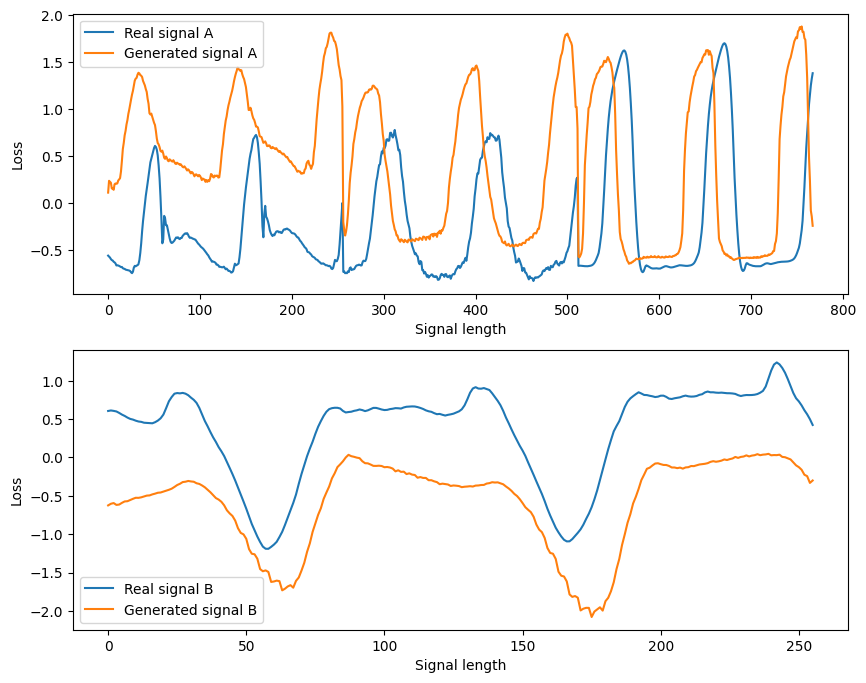

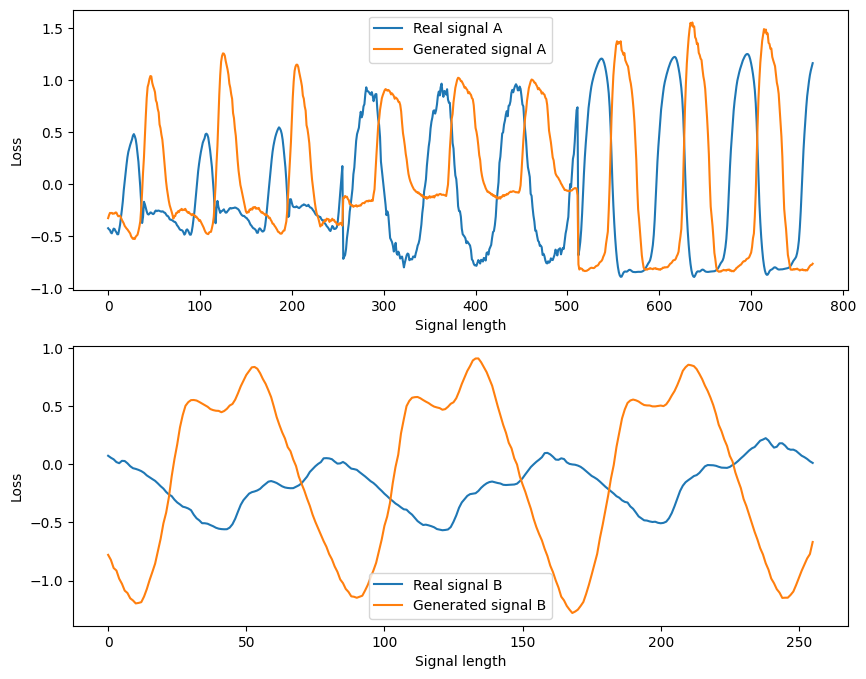

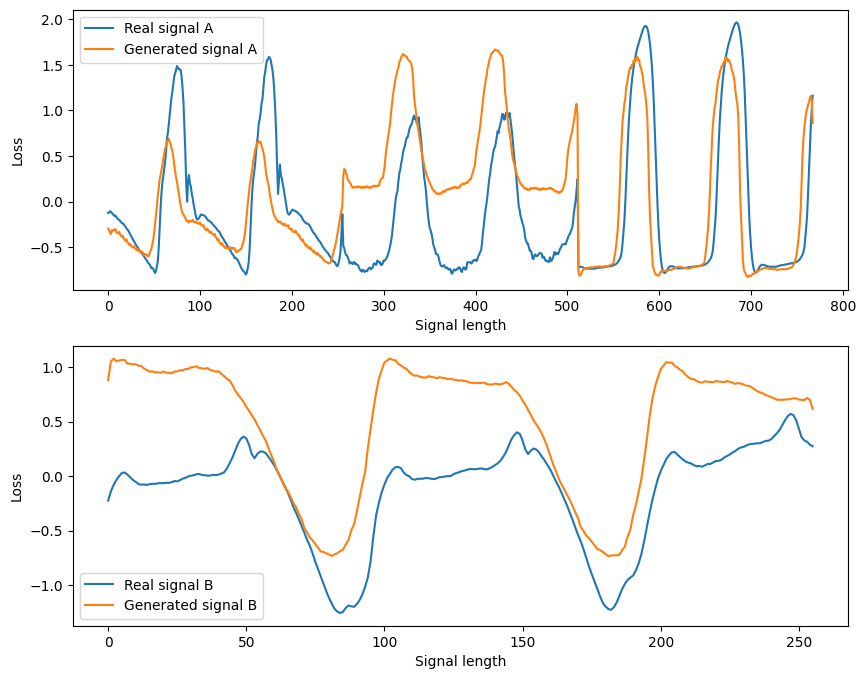

In [19]:
# Generate signals
idx = 0             
phases = df['Phasenzuordnung'].unique()
for sig_A, sig_B, phase, intervention in gen_loader:
    if idx == 3:
        break                 
                    
    sig_A = sig_A.float()
    sig_B = sig_B.float()
    sig_A = sig_A.to(DEVICE)
    sig_B = sig_B.to(DEVICE)
    phase = phase.to(DEVICE)
    intervention = intervention.to(DEVICE)

    fake_B = gen_B(sig_A, phase, intervention)
    fake_A = gen_A(sig_B, phase, intervention)

                        
    fake_B = fake_B.reshape(-1)
    fake_A = fake_A.reshape(-1)
    sig_A = sig_A.reshape(-1)
    sig_B = sig_B.reshape(-1)

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(sig_A.cpu().detach().numpy(), label= 'Real signal A')
    ax[0].plot(fake_A.cpu().detach().numpy(), label= 'Generated signal A')
    ax[0].set_xlabel('Signal length')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(sig_B.cpu().detach().numpy(), label= 'Real signal B')
    ax[1].plot(fake_B.cpu().detach().numpy(), label= 'Generated signal B')
    ax[1].set_xlabel('Signal length')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    # # plot generated signals and real signals
    # plt.figure(figsize=(15, 5))
    # plt.plot(sig_A.cpu().detach().numpy(), label= 'Real signal A')
    # plt.plot(sig_B.cpu().detach().numpy(), label= 'Real signal B')
    # plt.plot(fake_A.cpu().detach().numpy(), label= 'Generated signal A')
    # plt.plot(fake_B.cpu().detach().numpy(), label= 'Generated signal B')
    # plt.title('Generated signals vs real signals')
    # plt.legend()

    idx += 1              

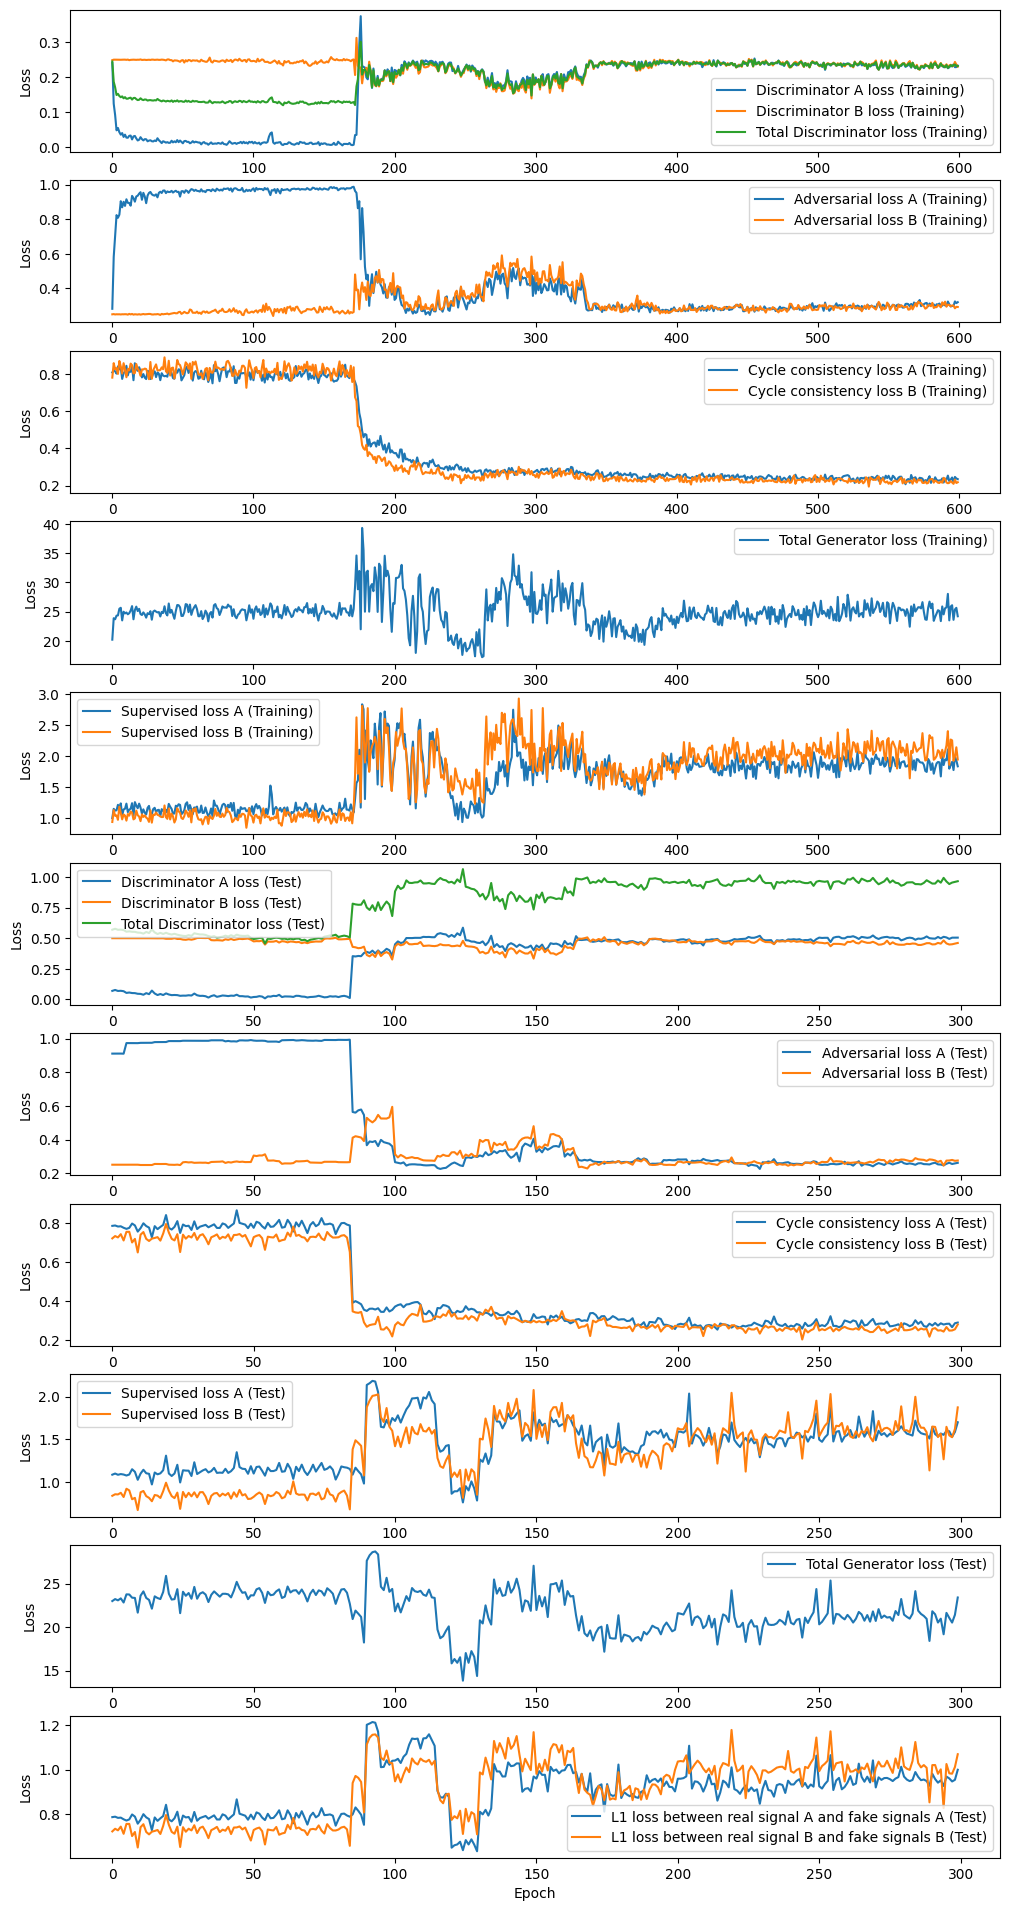

Selected losses for the test dataset after the last epoch:


L1 loss between real signal A and fake signals A:  0.9994072318077087

L1 loss between real signal B and fake signals B:  1.0693788528442383

L1 loss between real signal A and fake signal B:  0.9584136009216309

L1 loss between real signal B and fake signal A:  0.851169764995575

Discrminator A loss:  0.5044663548469543

Discrminator B loss:  0.46092867851257324

Total Discriminator loss:  0.9653950333595276

Adversaral loss A:  0.262046217918396

Adversaral loss B:  0.27562710642814636

Cycle consistency loss A:  0.28887468576431274

Cycle consistency loss B:  0.2788679599761963

Supervised loss A:  1.700961709022522

Supervised loss B:  1.8749815225601196

Total Generator loss:  23.406795501708984


In [20]:
# ----------------------------------- #
# -------------- PLOT --------------- #
# ----------------------------------- #

# Plot training losses in different subplots

fig, ax = plt.subplots(11, 1, figsize=(12, 24))
ax[0].plot(train_losses['Discriminator A loss'], label= 'Discriminator A loss (Training)')
ax[0].plot(train_losses['Discriminator B loss'], label= 'Discriminator B loss (Training)')
ax[0].plot(train_losses['Total Discriminator loss'], label= 'Total Discriminator loss (Training)')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
#ax[0].set_title('Training Discriminator Loss')

ax[1].plot(train_losses['Adversarial loss A'], label= 'Adversarial loss A (Training)')
ax[1].plot(train_losses['Adversarial loss B'], label= 'Adversarial loss B (Training)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
#ax[1].set_title('Training Adversarial Loss')
ax[2].plot(train_losses['Cycle consistency loss A'], label= 'Cycle consistency loss A (Training)')
ax[2].plot(train_losses['Cycle consistency loss B'], label= 'Cycle consistency loss B (Training)')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
#ax[2].set_title('Training Cycle Consistency Loss')
ax[3].plot(train_losses['Total Generator loss'], label= 'Total Generator loss (Training)')
ax[3].set_xlabel('Epoch')
ax[3].set_ylabel('Loss')
ax[3].legend()
#ax[3].set_title('Training Total Generator Loss')
ax[4].plot(train_losses['Supervised loss A'], label = 'Supervised loss A (Training)')
ax[4].plot(train_losses['Supervised loss B'], label = 'Supervised loss B (Training)')
ax[4].set_xlabel('Epoch')
ax[4].set_ylabel('Loss')
ax[4].legend()

# Plot test losses in different subplots

ax[5].plot(test_losses['Discriminator A loss'], label= 'Discriminator A loss (Test)')
ax[5].plot(test_losses['Discriminator B loss'], label= 'Discriminator B loss (Test)')
ax[5].plot(test_losses['Total Discriminator loss'], label= 'Total Discriminator loss (Test)')
ax[5].set_xlabel('Epoch')
ax[5].set_ylabel('Loss')
ax[5].legend()
#ax[4].set_title('Test Discriminator Loss')

ax[6].plot(test_losses['Adversarial loss A'], label= 'Adversarial loss A (Test)')
ax[6].plot(test_losses['Adversarial loss B'], label= 'Adversarial loss B (Test)')
ax[6].set_xlabel('Epoch')
ax[6].set_ylabel('Loss')
ax[6].legend()
#ax[5].set_title('Test Adversarial Loss')

ax[7].plot(test_losses['Cycle consistency loss A'], label= 'Cycle consistency loss A (Test)')
ax[7].plot(test_losses['Cycle consistency loss B'], label= 'Cycle consistency loss B (Test)')
ax[7].set_xlabel('Epoch')
ax[7].set_ylabel('Loss')
ax[7].legend()
#ax[6].set_title('Test Cycle Consistency Loss')

ax[8].plot(test_losses['Supervised loss A'], label = 'Supervised loss A (Test)')
ax[8].plot(test_losses['Supervised loss B'], label = 'Supervised loss B (Test)')
ax[8].set_xlabel('Epoch')
ax[8].set_ylabel('Loss')
ax[8].legend()

ax[9].plot(test_losses['Total Generator loss'], label= 'Total Generator loss (Test)')
ax[9].set_xlabel('Epoch')
ax[9].set_ylabel('Loss')
ax[9].legend()
#ax[7].set_title('Test Total Generator Loss')

ax[10].plot(test_losses['L1 loss between real signal A and fake signals A'], label= 'L1 loss between real signal A and fake signals A (Test)')
ax[10].plot(test_losses['L1 loss between real signal B and fake signals B'], label= 'L1 loss between real signal B and fake signals B (Test)')
ax[10].set_xlabel('Epoch')
ax[10].set_ylabel('Loss')
ax[10].legend()
#ax[8].set_title('Test L1 Loss')

plt.show()

print('Selected losses for the test dataset after the last epoch:\n')
print('\nL1 loss between real signal A and fake signals A: ', test_losses['L1 loss between real signal A and fake signals A'][-1])
print('\nL1 loss between real signal B and fake signals B: ', test_losses['L1 loss between real signal B and fake signals B'][-1])
print('\nL1 loss between real signal A and fake signal B: ', test_losses['L1_realA_fakeB'][-1])
print('\nL1 loss between real signal B and fake signal A: ', test_losses['L1_realB_fakeA'][-1])
print('\nDiscrminator A loss: ', test_losses['Discriminator A loss'][-1])
print('\nDiscrminator B loss: ', test_losses['Discriminator B loss'][-1])
print('\nTotal Discriminator loss: ', test_losses['Total Discriminator loss'][-1])
if ADVERSARIAL:
    print('\nAdversaral loss A: ', test_losses['Adversarial loss A'][-1])
    print('\nAdversaral loss B: ', test_losses['Adversarial loss B'][-1])
if CYCLE:
    print('\nCycle consistency loss A: ', test_losses['Cycle consistency loss A'][-1])
    print('\nCycle consistency loss B: ', test_losses['Cycle consistency loss B'][-1])
if SUPERVISED:
    print('\nSupervised loss A: ', test_losses['Supervised loss A'][-1])
    print('\nSupervised loss B: ', test_losses['Supervised loss B'][-1])
if IDENTITY:
    pass
print('\nTotal Generator loss: ', test_losses['Total Generator loss'][-1])

#### only cycle consistency

L1 loss between real signal A and fake signals A:  1.1316797733306885

L1 loss between real signal B and fake signals B:  1.0733401775360107

L1 loss between real signal A and fake signal B:  1.7766772508621216

L1 loss between real signal B and fake signal A:  1.4874348640441895

Discrminator A loss:  0.1503942608833313

Discrminator B loss:  0.3994024693965912

Total Discriminator loss:  0.5497967004776001

Cycle consistency loss A:  0.19478408992290497

Cycle consistency loss B:  0.17089401185512543

Total Generator loss:  0.3656781017780304

#### cycle consistency and adversaral

L1 loss between real signal A and fake signals A:  0.8851507306098938

L1 loss between real signal B and fake signals B:  0.8195056319236755

L1 loss between real signal A and fake signal B:  1.3313361406326294

L1 loss between real signal B and fake signal A:  1.3179595470428467

Discrminator A loss:  0.49969780445098877

Discrminator B loss:  0.5000841617584229

Total Discriminator loss:  0.9997819662094116

Adversaral loss A:  0.2503548562526703

Adversaral loss B:  0.25005248188972473

Cycle consistency loss A:  0.19431807100772858

Cycle consistency loss B:  0.186402827501297

Total Generator loss:  0.8811282515525818

#### cycle, supervised, adversarial (all = 1.0)

L1 loss between real signal A and fake signals A:  0.27029305696487427

L1 loss between real signal B and fake signals B:  0.4612604081630707

L1 loss between real signal A and fake signal B:  1.1757029294967651

L1 loss between real signal B and fake signal A:  1.0735013484954834

Discrminator A loss:  0.49906790256500244

Discrminator B loss:  0.4996219277381897

Total Discriminator loss:  0.9986898303031921

Adversaral loss A:  0.25107505917549133

Adversaral loss B:  0.2503276467323303

Cycle consistency loss A:  0.14452360570430756

Cycle consistency loss B:  0.10823661088943481
...

Supervised loss B:  0.38460054993629456

Total Generator loss:  1.2835817337036133